# Jet tagging with Quantum Machine Learning @ LHCb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Dataset
The dataset is stored in two csv files produced using LHCb OpenData tuples that are publicly available.
Test dataset contains also variables needed afterwards for analysis.

In [2]:
import pandas as pd
# All Input variables
allvariables = ['idx',                                     # jet index
             'Jet_foundMuon', 'Jet_muon_q', 'Jet_muon_PT', #  global (anti-)muon variables
             'Jet_PT', 'Jet_ETA', 'Jet_PHI',               #  global jet variables
             'mu_Q', 'mu_pTrel','mu_dist',                 # (anti-)muon
             'k_Q', 'k_pTrel','k_dist',                    # (anti-)kaon
             'pi_Q', 'pi_pTrel','pi_dist',                 # (anti-)pion
             'e_Q', 'e_pTrel','e_dist',                    # (anti-)electron
             'p_Q', 'p_pTrel','p_dist',                    # (anti-)proton
             'Jet_QTOT',                                   # Weighted Jet Total Charge
             'Jet_LABEL']                                  # Ground Truth label

# Input variables of the quantum circuit
variables = ['idx',                                        # jet index
             'mu_Q', 'mu_pTrel','mu_dist',                 # (anti-)muon
             'k_Q', 'k_pTrel','k_dist',                    # (anti-)kaon
             'pi_Q', 'pi_pTrel','pi_dist',                 # (anti-)pion
             'e_Q', 'e_pTrel','e_dist',                    # (anti-)electron
             'p_Q', 'p_pTrel','p_dist',                    # (anti-)proton
             'Jet_QTOT',                                   # Weighted Jet Total Charge
             'Jet_LABEL']                                  # Ground Truth label

# Events are split in two subsets for training and testing
trainData = pd.read_csv("./data/trainData.csv")[variables]
testData = pd.read_csv("prova_test.csv")[allvariables]

In [3]:
trainData

,idx,Jet_foundMuon,Jet_muon_q,Jet_muon_PT,Jet_PT,Jet_ETA,Jet_PHI,mu_Q,mu_pTrel,mu_dist,...,pi_pTrel,pi_dist,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL
0,67534_bbdw50V2,False,0,-99.0,54352.419775,2.601848,-2.097930,0.0,0.0000,0.000000,...,829.630183,0.028973,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.042473,0
1,206375_bbup50V2,False,0,-99.0,47565.417878,2.772848,-0.657706,0.0,0.0000,0.000000,...,684.807325,0.107355,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.359669,1
2,210480_bbup20V2,False,0,-99.0,32063.111625,2.902357,1.269344,0.0,0.0000,0.000000,...,789.216558,0.127735,-1.0,39.494456,0.308602,0.0,0.000000,0.000000,0.346662,0
3,152795_bbdw20V2,False,0,-99.0,43709.960975,3.237630,1.895647,0.0,0.0000,0.000000,...,372.126496,0.466525,-1.0,91.257326,0.077849,-1.0,425.217589,0.504940,-0.489851,0
4,70915_bbup50V2,False,0,-99.0,30147.310824,2.727333,0.226297,0.0,0.0000,0.000000,...,81.874805,0.401463,1.0,119.413691,0.292057,0.0,0.000000,0.000000,0.203506,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295213,29075_bbup50V2,False,0,-99.0,77805.362249,2.873823,-2.800296,0.0,0.0000,0.000000,...,636.654680,0.382445,1.0,125.405735,0.095220,-1.0,852.591020,0.178009,0.035330,1
295214,1599_bbdw50V2,False,0,-99.0,55719.790285,2.223532,-2.812439,0.0,0.0000,0.000000,...,782.683029,0.046080,1.0,208.757683,0.399932,0.0,0.000000,0.000000,0.030041,0
295215,201530_bbdw20V2,False,0,-99.0,31750.298370,3.639299,0.545732,0.0,0.0000,0.000000,...,377.646592,0.072755,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.052522,1
295216,11186_bbdw15V2,False,0,-99.0,23366.769833,2.344265,-2.199778,1.0,389.5331,0.235951,...,243.536989,0.145758,1.0,100.103286,0.075900,-1.0,1771.912926,0.340930,-0.435332,0


 ## Preprocessing
 The variables need to be preprocessed before the training process. Here we adopt a technique that suited well for our QML application: firstly data are normalized using a StandardScaler, then the arctan function is applied.

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(pd.concat([trainData,testData])[variables[1:-1]])
trainData[variables[1:-1]] = np.arctan(trainData[variables[1:-1]])
testData[variables[1:-1]] = np.arctan(testData[variables[1:-1]])

In [5]:
trainData

,idx,mu_Q,mu_pTrel,mu_dist,k_Q,k_pTrel,k_dist,pi_Q,pi_pTrel,pi_dist,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL
0,67534_bbdw50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.569591,0.028965,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.042447,0
1,206375_bbup50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.569336,0.106945,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.345263,1
2,210480_bbup20V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.785398,1.569529,0.127047,-0.785398,1.545482,0.299330,0.000000,0.000000,0.000000,0.333698,0
3,152795_bbdw20V2,0.000000,0.000000,0.000000,-0.785398,1.569120,0.484652,-0.785398,1.568109,0.436511,-0.785398,1.559839,0.077693,-0.785398,1.568445,0.467592,-0.455495,0
4,70915_bbup50V2,0.000000,0.000000,0.000000,-0.785398,1.566888,0.050296,0.785398,1.558583,0.381767,0.785398,1.562422,0.284154,0.000000,0.000000,0.000000,0.200765,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295213,29075_bbup50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.785398,1.569226,0.365282,0.785398,1.562822,0.094934,-0.785398,1.569623,0.176163,0.035316,1
295214,1599_bbdw50V2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.785398,1.569519,0.046047,0.785398,1.566006,0.380448,0.000000,0.000000,0.000000,0.030032,0
295215,201530_bbdw20V2,0.000000,0.000000,0.000000,-0.785398,1.566811,0.623772,0.785398,1.568148,0.072627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052474,1
295216,11186_bbdw15V2,0.785398,1.568229,0.231713,0.000000,0.000000,0.000000,-0.785398,1.566690,0.144739,0.785398,1.560807,0.075755,-0.785398,1.570232,0.328572,-0.410589,0


## QML Model
![Circuit](img/circuit.png)



In [6]:
import pennylane as qml

n_qubits = 4
n_layers = 4

# default.qubit.tf is a quantum simulator that uses Tensorflow as backend
# it supports back-propagation, which is useful with a large number of
# parameters

dev = qml.device("default.qubit.tf",wires=n_qubits) # Device initialization

# In pennylane, quantum circuits are mostly defined via the qnode decorator
# applied to a function which describes the quantum gates to be applied to 
# each qubit and, finally, the measurement to be performed.

@qml.qnode(dev, interface="tf", diff_method='backprop')
def circuit(inputs,weights):
    
# The AmplitudeEmbedding template implements the embedding of 2**N features
# in N qubits. Amplitudes must be < 0, so a normalization is performed. 
    qml.templates.AmplitudeEmbedding(inputs,wires=range(n_qubits),normalize=True)
    
# The StronglyEntanglingLayers templates implements a variable number of
# layers made of rotation around all the axes and CNOT gates. Rotation angles
# are passed via the weights parameter of dimension (n_layers,n_qubits,3)
    qml.templates.StronglyEntanglingLayers(weights, wires=range(4))
    
# Finally, the expectation value of the Sigma_Z Pauli matrix of the first qubit
# is measured. It will range from -1 to 1 and will be mapped to a label prediction
    return qml.expval(qml.PauliZ(0))

2021-07-07 13:12:08.709029: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-07 13:12:08.709326: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-07 13:12:08.712208: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


## Keras model
A great feature of pennylane is that it can be integrated flawlessly inside Keras and PyTorch models. This allows for the developing of hybrid quantum-classical machine learning models. 

In [7]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Activation

# We generate the quantum Keras layer, specifiying the dimension of the
# trainable parameters and of the output of the layer.
quantum_layer = qml.qnn.keras.KerasLayer(circuit,weight_shapes={'weights':(n_layers,n_qubits,3)},output_dim=1)

# Finally, we build a Sequencial model appending a sigmoid function to
# the quantum layer
model = Sequential([quantum_layer,Activation('sigmoid')])

## Training
For the training part you can define:
- learning rate
- loss function
- training and validation size
- number of epochs

In [8]:
from tensorflow.keras.optimizers import Adam

# Let's pick an optimizer
opt = Adam(learning_rate=0.02)

# We choose the Mean Square Error as our loss function and a binary
# accuracy as our metric
model.compile(opt, loss="mse",metrics=['binary_accuracy']) 

# We fix the size of the training dataset and validation dataset
training_size   = 200
validation_size = 200

# And build a balanced training sample ...
bsample = trainData[trainData.Jet_LABEL == 0].sample(training_size//2)
bbarsample = trainData[trainData.Jet_LABEL == 1].sample(training_size//2)

training_sample = pd.concat([bsample,bbarsample]).sample(frac=1.0)

X = training_sample[variables[1:-1]]
Y = training_sample[variables[-1]]

# And validation sample
val_bsample = testData[testData.Jet_LABEL == 0].sample(validation_size//2)
val_bbarsample = testData[testData.Jet_LABEL == 1].sample(validation_size//2)

validation_sample = pd.concat([val_bsample,val_bbarsample]).sample(frac=1.0)

val_X = validation_sample[variables[1:-1]]
val_Y = validation_sample[variables[-1]]

# Finally, we start the training process
n_epochs = 10
history_fit = model.fit(X,Y,epochs=n_epochs,validation_data=(val_X,val_Y))

2021-07-07 13:12:08.999185: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-07 13:12:08.999684: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2300030000 Hz
Epoch 1/10
7/7 [==============================] - 18s 3s/step - loss: 0.2580 - binary_accuracy: 0.4698 - val_loss: 0.2535 - val_binary_accuracy: 0.5670
Epoch 2/10
7/7 [==============================] - 18s 3s/step - loss: 0.2543 - binary_accuracy: 0.5171 - val_loss: 0.2503 - val_binary_accuracy: 0.5580
Epoch 3/10
7/7 [==============================] - 18s 3s/step - loss: 0.2515 - binary_accuracy: 0.5502 - val_loss: 0.2493 - val_binary_accuracy: 0.5402
Epoch 4/10
7/7 [==============================] - 18s 3s/step - loss: 0.2430 - binary_accuracy: 0.5432 - val_loss: 0.2488 - val_binary_accuracy: 0.5625
Epoch 5/10
7/7 [==============================] - 18s 3s/step - loss: 0.2357 - binary_accuracy: 0.6188 - val_loss: 0.250

## Training results
Standard training results such as the loss function and the accuracy can be plotted with respect to the number of epochs.

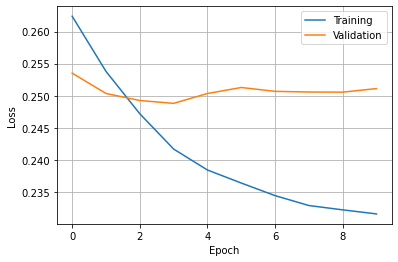

In [9]:
plt.plot(history_fit.history['loss'], label="Training")
plt.plot(history_fit.history['val_loss'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

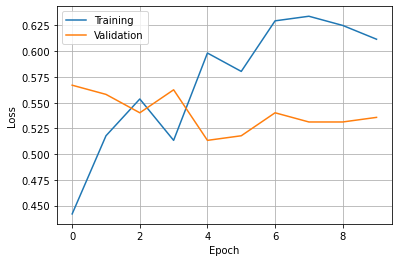

In [10]:
plt.plot(history_fit.history['binary_accuracy'], label="Training")
plt.plot(history_fit.history['val_binary_accuracy'], label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Testing
We now perform some testing on a test dataset. The workflow is the following:
1. get a test data with a balanced number of b and bbar events
2. evaluate the model on the test dataset
3. get prediction for each event

In [11]:

# Let's also build a balanced testing sample
testing_size = 1000

test_bsample = testData[testData.Jet_LABEL == 0].sample(testing_size//2)
test_bbarsample = testData[testData.Jet_LABEL == 1].sample(testing_size//2)

testing_sample = pd.concat([test_bsample,test_bbarsample]).sample(frac=1.0)

test_X = testing_sample[variables[1:-1]]
test_Y = testing_sample[variables[-1]]

# And let's predict the label with our trained model
test_predY= model.predict(test_X)
testing_sample['RawPred'] = test_predY
testing_sample['Jet_PREDLABEL'] = np.round(test_predY)

## Testing results

### Prediction distribution

[]

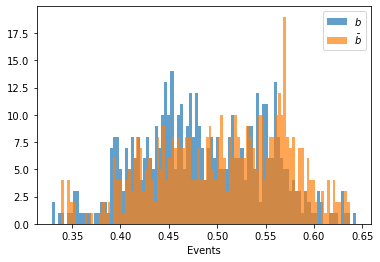

In [12]:
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 0]['RawPred'],bins=100,alpha=0.7,label="$b$")
plt.hist(testing_sample[testing_sample['Jet_LABEL'] == 1]['RawPred'],bins=100,alpha=0.7,label="$\\bar{b}$")
plt.xlabel("RawPred")
plt.xlabel("Events")
plt.legend()
plt.plot()

## Receiver Operating Characteristic (ROC) curve and Area Under Curve (AUC)
Usual metrics such as ROC curve and AUC can be computed.

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr,tpr, _ = roc_curve(testing_sample['Jet_LABEL'],testing_sample['RawPred'])
auc = roc_auc_score(testing_sample['Jet_LABEL'],testing_sample['RawPred'])

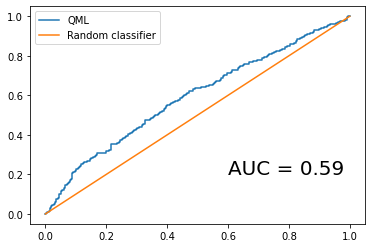

In [14]:
plt.plot(fpr,tpr,label='QML')
plt.plot([0,1],[0,1], label='Random classifier')
plt.text(0.6,0.2,f"AUC = {auc:.2}",fontsize=20)
plt.legend()

## Saving predictions
Once you have tested your dataset you can easily save your model prediction for future analysis.


In [15]:
testing_sample

,idx,Jet_foundMuon,Jet_muon_q,Jet_muon_PT,Jet_PT,Jet_ETA,Jet_PHI,mu_Q,mu_pTrel,mu_dist,...,e_Q,e_pTrel,e_dist,p_Q,p_pTrel,p_dist,Jet_QTOT,Jet_LABEL,RawPred,Jet_PREDLABEL
102491,92308_bbdw50V2,False,0,-99.0,70311.897921,3.813177,-1.046385,0.000000,0.000000,0.000000,...,-0.785398,1.568961,0.218483,0.000000,0.00000,0.000000,-0.429090,1,0.439694,0.0
234894,106569_bbup50V2,False,0,-99.0,56919.766305,3.462864,2.399330,0.785398,1.568324,0.245142,...,0.000000,0.000000,0.000000,-0.785398,1.56958,0.240027,-0.356110,0,0.397649,0.0
36124,61027_bbup20V2,False,0,-99.0,22066.484046,3.823096,0.163485,0.000000,0.000000,0.000000,...,0.785398,1.567782,0.109493,0.000000,0.00000,0.000000,-0.414433,0,0.472131,0.0
282610,269524_bbdw50V2,False,0,-99.0,65727.908503,2.313250,-1.939999,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.622295,0,0.628796,1.0
61409,278983_bbup50V2,False,0,-99.0,34991.250015,2.510715,-1.984452,0.000000,0.000000,0.000000,...,-0.785398,1.463052,0.035903,0.000000,0.00000,0.000000,-0.209700,0,0.477479,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36446,98152_bbup20V2,False,0,-99.0,33463.861687,2.377611,-2.281776,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.348793,1,0.535091,1.0
40763,129600_bbdw50V2,False,0,-99.0,65103.375194,2.232173,-3.066863,0.000000,0.000000,0.000000,...,0.785398,1.565271,0.396660,0.000000,0.00000,0.000000,0.096883,0,0.546271,1.0
181936,101572_bbup20V2,False,0,-99.0,34899.687664,2.477321,-2.811797,0.785398,1.568380,0.144012,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.476552,1,0.574127,1.0
290553,127595_bbdw50V2,False,0,-99.0,57894.027435,2.876614,-2.602449,0.000000,0.000000,0.000000,...,0.785398,1.564153,0.417937,0.000000,0.00000,0.000000,0.021921,1,0.543605,1.0


In [16]:
# Finally, we can save our model prediction for future analysis (bbar asymmetry estimation,
# tagging performance analysis, ...)

testing_sample.to_csv("data_with_predictions.csv",index=False)

In [17]:
def MC_ApplyAlgTagging(df, netype="Quantum", mu_cut=5000):
    """
    Performs the MLAlg tagging for each jet, and applies a probabilities R/L cuts or a muonPT cut.
    netype is used to identify columns name. 
    -> Right cut is for label 1, left cut for label 0 

    COLUMNS REQUIRED          COLUMNS ADDED
    Jet_foundMuon (if MuTag)  "Jet_%s_Charge"%nettype (0: Not tagged)    
    Jet_muon_q    (if MuTag)
    Jet_muon_PT   (if MuTag)
    Jet_%sProb"%netype       
    """
    if (netype=="MuTag"):
      df['Jet_MuTag_Charge'] = 0
      tt_Jet = (df['Jet_foundMuon'] == 1) & (df['Jet_muon_PT'] > mu_cut)
      df.loc[tt_Jet, 'Jet_MuTag_Charge'] = df.loc[tt_Jet].Jet_muon_q
    else:
      df['Jet_%s_Charge'%netype] = 0
      tt_Jet_1 = (df["Jet_%sProb"%netype] > 0.5)
      tt_Jet_0 = (df["Jet_%sProb"%netype] < 0.5)
      df.loc[tt_Jet_1,'Jet_%s_Charge'%netype] =  1
      df.loc[tt_Jet_0,'Jet_%s_Charge'%netype] =  -1

def MC_ApplyAlgChecking(df, netype="Quantum"):
    """
    Checks the result of the Alg tagging by comparing the guess with the MC-truth.
    netype is used to identify columns name. 

    COLUMNS REQUIRED           COLUMNS ADDED

    "Jet_%s_Charge"%netype     "Jet_%s_Check"%netype     
    Jet_MATCHED_CHARGE
    """
    df['Jet_%s_Check'%netype] = 0

    tt_correct_jet = (df['Jet_%s_Charge'%netype] != 0) & (df['Jet_%s_Charge'%netype] == df.Jet_MATCHED_CHARGE)
    tt_notcorrect_jet = (df['Jet_%s_Charge'%netype] != 0) & (df['Jet_%s_Charge'%netype] != df.Jet_MATCHED_CHARGE)

    df.loc[tt_correct_jet, 'Jet_%s_Check'%netype] = 1
    df.loc[tt_notcorrect_jet, 'Jet_%s_Check'%netype] = -1

In [18]:
testing_sample.rename(columns={"Jet_LABEL": "Jet_MATCHED_CHARGE"}, inplace=True)
testing_sample.rename(columns={"RawPred": "Jet_QuantumProb"}, inplace=True)
MC_ApplyAlgTagging(testing_sample, "Quantum")
MC_ApplyAlgChecking(testing_sample, "Quantum")
print(testing_sample)

                    idx  Jet_foundMuon  Jet_muon_q  Jet_muon_PT        Jet_PT  \
102491   92308_bbdw50V2          False           0        -99.0  70311.897921   
234894  106569_bbup50V2          False           0        -99.0  56919.766305   
36124    61027_bbup20V2          False           0        -99.0  22066.484046   
282610  269524_bbdw50V2          False           0        -99.0  65727.908503   
61409   278983_bbup50V2          False           0        -99.0  34991.250015   
...                 ...            ...         ...          ...           ...   
36446    98152_bbup20V2          False           0        -99.0  33463.861687   
40763   129600_bbdw50V2          False           0        -99.0  65103.375194   
181936  101572_bbup20V2          False           0        -99.0  34899.687664   
290553  127595_bbdw50V2          False           0        -99.0  57894.027435   
173217  256107_bbup50V2          False           0        -99.0  61673.879413   

         Jet_ETA   Jet_PHI 

In [19]:
def MC_GetAlgPerformances(jet_df, netype="Quantum"):
    """
    Extract Alg performance and associated uncertainties.
    netype is used to identify columns name.

    COLUMNS REQUIRED
    'Jet_%s_Check'%netype
    """
    N_tot = len(jet_df)

    N_tag = jet_df['Jet_%s_Check'%netype].value_counts()[1] + jet_df['Jet_%s_Check'%netype].value_counts()[-1]
    N_wrong = jet_df['Jet_%s_Check'%netype].value_counts()[-1]

    #Efficiency
    eps_eff = float(N_tag)/N_tot
    err_eps_eff = np.sqrt(eps_eff*(1-eps_eff)/N_tot)
    #Omega
    omega = float(N_wrong)/(N_tag)
    err_omega  = np.sqrt(omega*(1-omega)/N_tag)

    #Accuracy
    accuracy = 1- omega
    
    #Tagging Power
    eps_tag = (eps_eff * (1-2*omega)**2)
    #err_eps_tag = np.sqrt((N_tot*(eps_eff)*(1-eps_eff)) * Deps_DNtag(N_tot,N_wrong,N_tag)**2 + (N_tag*(omega)*(1-omega)) * Deps_DNw(N_tot,N_wrong,N_tag)**2)
    err_eps_tag = 0
    #print('tagging power = %s'%eps_tag)
    
    return eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy

In [20]:
bin_centers = []
half_widths = []

omegas = []
err_omegas = []
effs = []
err_effs = []
ptags = []
err_ptags = []
tot = []
accuracies = []

def MCAnalysis(jet_df, netype="Quantum", nbins=8, basepath="", legend=True):
    '''
    Performs the algorithms evaluation
    '''

    # Discretize variable into equal-sized buckets using jet PT
    out,bins = pd.qcut(jet_df.Jet_PT,nbins,retbins=True,labels=False)


    for i in range(nbins):
        bin_center = float((bins[i] + bins[i+1])/2)/1000
        half_width = float((bins[i+1] - bins[i])/2)/1000
        bin_centers.append(bin_center)
        half_widths.append(half_width)
    
        eps_eff,omega,eps_tag,err_eps_eff,err_omega,err_eps_tag,N_tot,accuracy = MC_GetAlgPerformances(jet_df[out == i], netype)
        omegas.append(omega*100)
        err_omegas.append(err_omega*100)
        ptags.append(eps_tag*100)
        err_ptags.append(err_eps_tag*100)
        effs.append(eps_eff*100)
        err_effs.append(err_eps_eff*100)

 
    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, ptags, xerr=half_widths, yerr=err_ptags, fmt='o', capsize=2, ms=8)
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{tag} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.530,0.360,"LHCb Simulation\nOpen Data", ma='right', fontsize=18)

    fig.savefig("./TagPower_%s.png"%(netype), bbox_inches='tight')
    #plt.close()
    plt.show()

    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, effs, xerr=half_widths, yerr=err_effs, fmt='o', capsize=2, ms=8)
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{eff} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.530,0.360,"LHCb Simulation\nOpen Data", ma='right', fontsize=18)

    fig.savefig("./efficiency_%s.png"%(netype), bbox_inches='tight')
    #plt.close()
    plt.show()

    fig = plt.figure(figsize=(6,6))
    plt.errorbar(bin_centers, omegas, xerr=half_widths, yerr=err_omegas, fmt='o', capsize=2, ms=8)
    plt.xlabel("$\mathrm{P_{T} \ (GeV)}$")
    plt.ylabel("$\mathrm{\epsilon_{eff} \ (\%)}$")

    plt.minorticks_on()
    plt.figtext(0.530,0.360,"LHCb Simulation\nOpen Data", ma='right', fontsize=18)

    fig.savefig("./mistag%s.png"%(netype), bbox_inches='tight')
    #plt.close()
    plt.show()

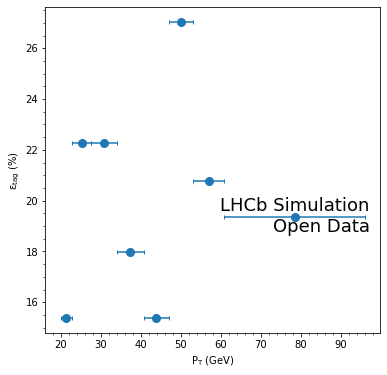

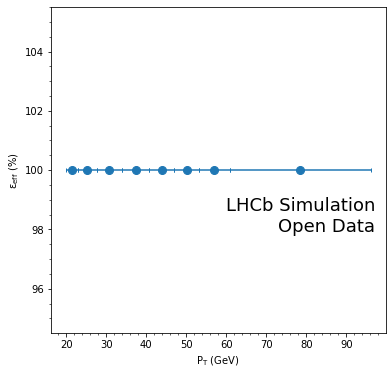

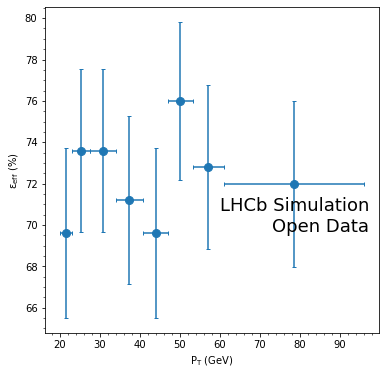

In [21]:
MCAnalysis(testing_sample)

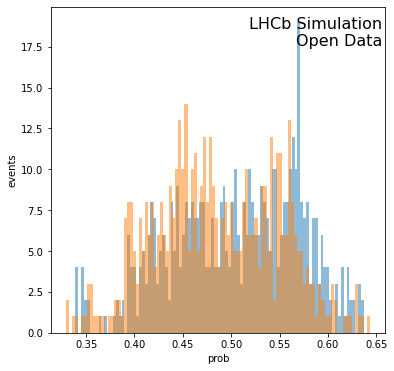

In [22]:
fig = plt.figure(figsize=(6,6))

plt.xlabel("prob")
plt.ylabel("events")

plt.hist(testing_sample.loc[testing_sample['Jet_MATCHED_CHARGE'] == 1, 'Jet_QuantumProb'], bins=100, alpha=0.5, label='b')
plt.hist(testing_sample.loc[testing_sample['Jet_MATCHED_CHARGE'] == 0, 'Jet_QuantumProb'], bins=100, alpha=0.5, label='bbar')

#plt.minorticks_on()
plt.figtext(0.585,0.790,"LHCb Simulation\nOpen Data", ma='right', fontsize=16)

#fig.savefig("./prob.png", bbox_inches='tight')
plt.show()